# Q Learning

## Spring mass system
Maximize the mass compression

 10%|▉         | 998/10000 [00:42<04:30, 33.30it/s] 

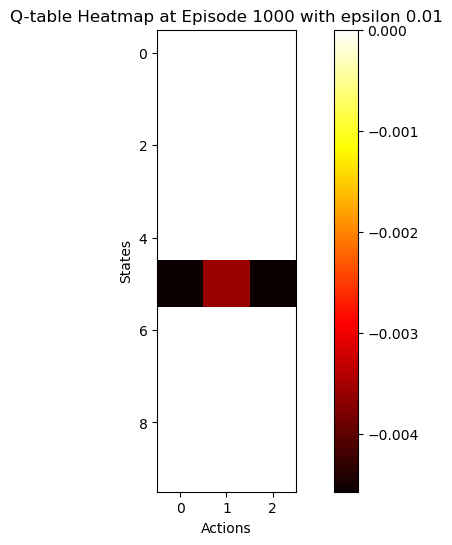

 20%|█▉        | 1996/10000 [01:13<04:12, 31.73it/s]

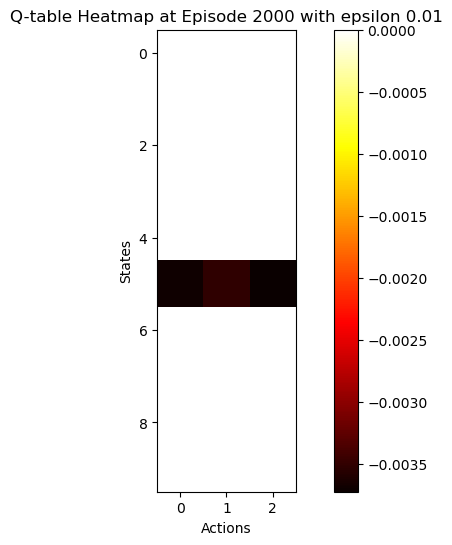

 30%|██▉       | 2997/10000 [01:45<03:40, 31.81it/s]

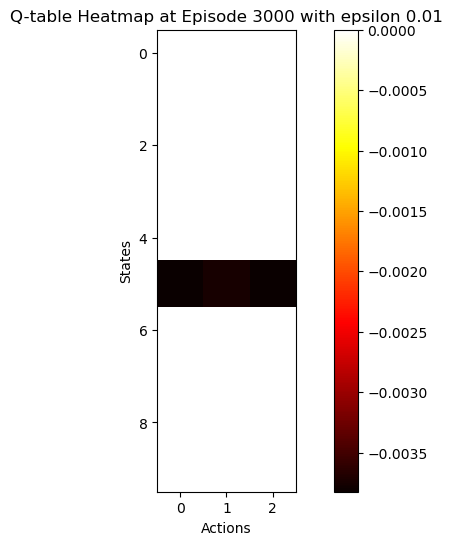

 40%|███▉      | 3996/10000 [02:16<03:01, 33.10it/s]

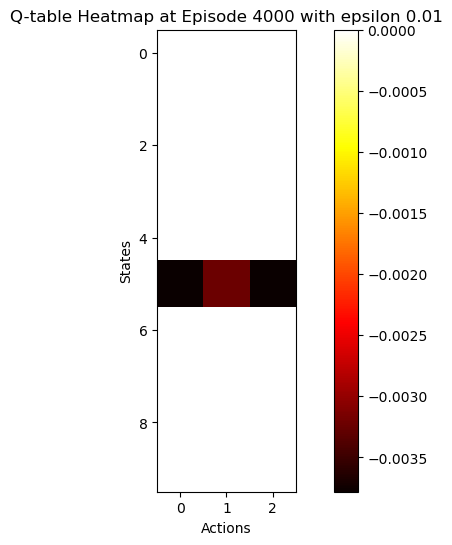

 50%|████▉     | 4996/10000 [02:47<02:40, 31.17it/s]

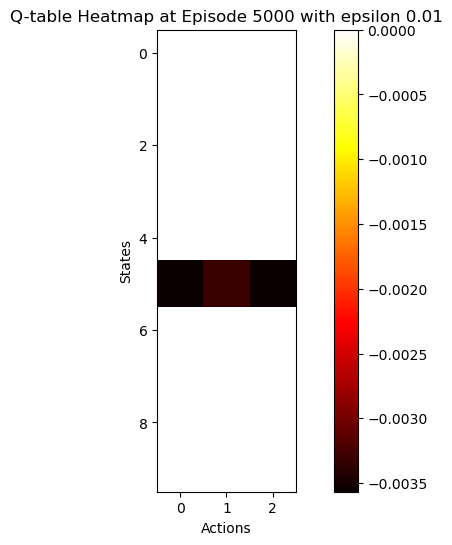

 60%|█████▉    | 5996/10000 [03:18<02:00, 33.17it/s]

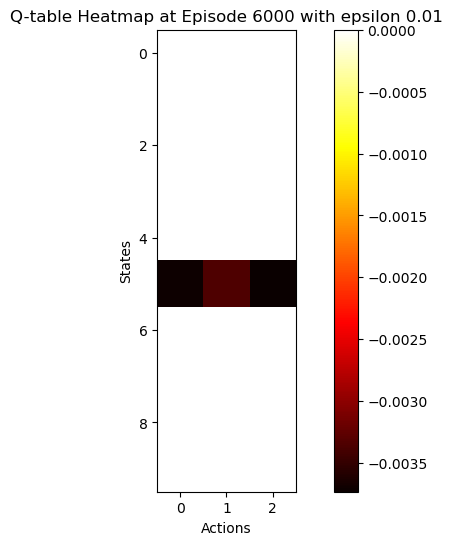

 70%|██████▉   | 6999/10000 [03:49<01:34, 31.91it/s]

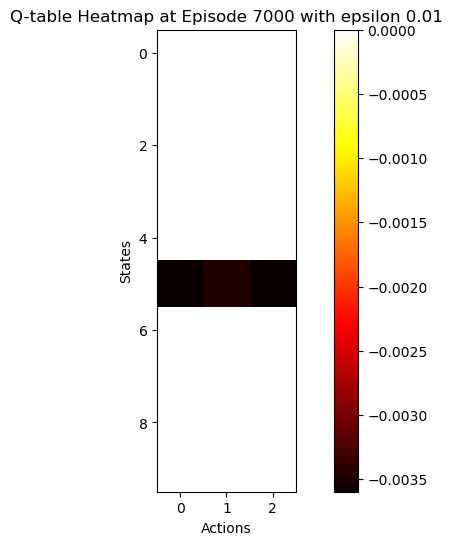

 80%|███████▉  | 7999/10000 [04:21<00:59, 33.76it/s]

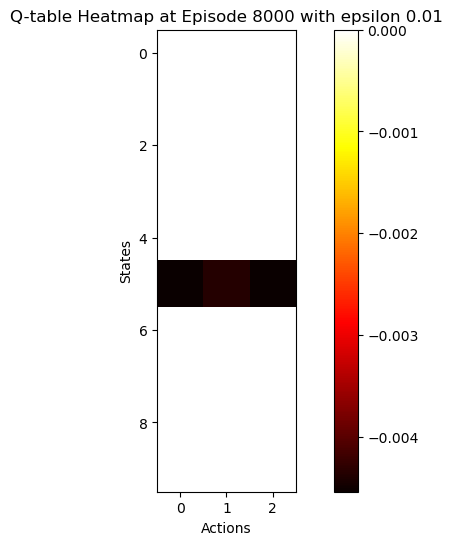

 90%|████████▉ | 8997/10000 [04:52<00:29, 33.54it/s]

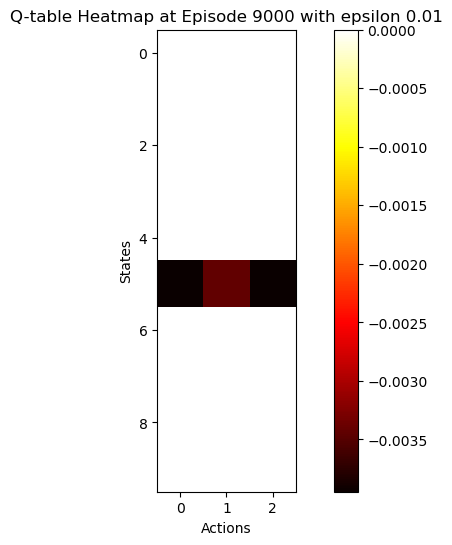

100%|█████████▉| 9996/10000 [05:23<00:00, 33.71it/s]

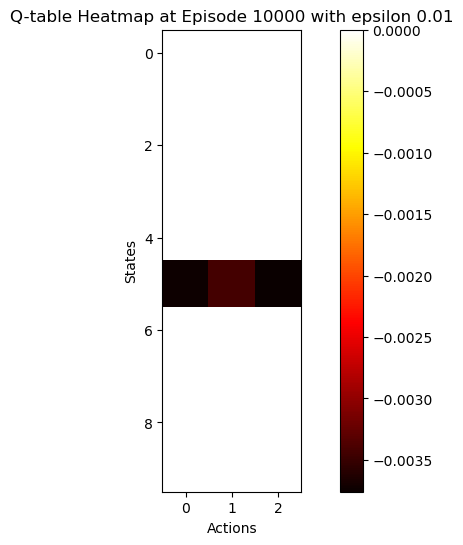

100%|██████████| 10000/10000 [05:33<00:00, 29.99it/s]


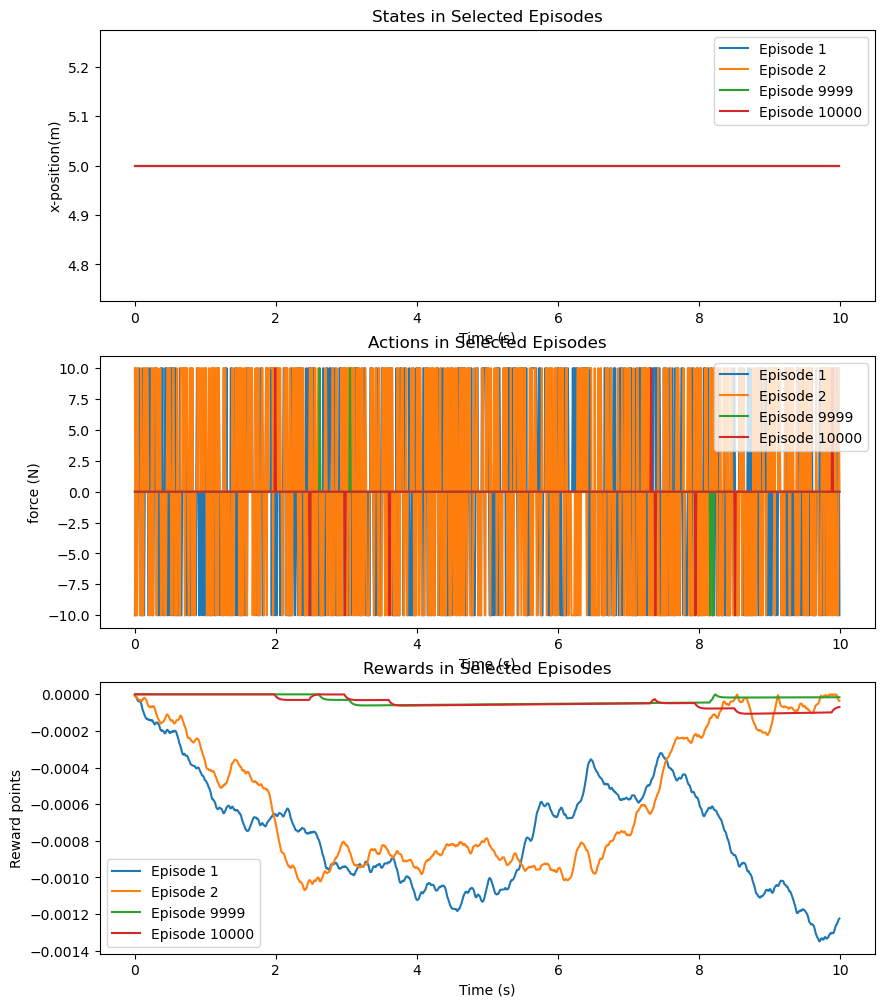

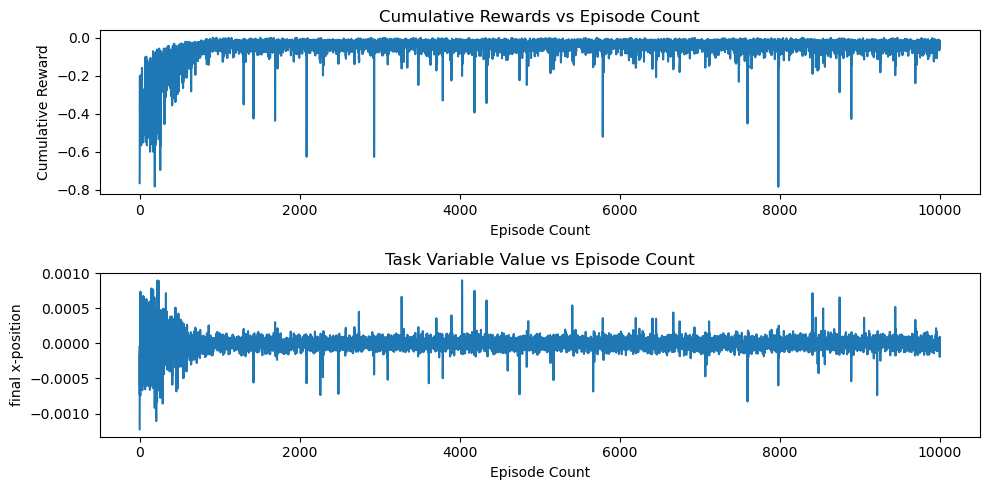

In [1]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import cv2
from tqdm import tqdm
import os

# Constants
EPISODES = 10000
EPISODE_LENGTH = 1000
SAMPLE_RATE = 0.01
LEARNING_RATE = 0.002
EPSILON_DECAY = 0.995
MIN_EPSILON = 0.01
GAMMA = 0.99
ACTIONS = [-10, 0, 10]  # Actions in the environment

# Initialize Q-table and epsilon
Q_table = np.zeros((10, len(ACTIONS)))  # 10 states, 3 actions
EPSILON = 1.0


# Define functions
def discretize_state(state_value):
    """Discretize the continuous state into 10 bins."""
    return int(np.digitize(state_value, np.linspace(-1, 1, 10)))

def choose_action(state):
    """Choose action using epsilon-greedy strategy."""
    if np.random.rand() < EPSILON:
        return np.random.choice(len(ACTIONS))  # Random action
    else:
        return np.argmax(Q_table[state])  # Greedy action

def step_environment(model,data,action):
    """Step the environment and return next state, reward, done."""
    data.ctrl[0] = action  # Apply force as action
    mujoco.mj_step(model, data)  # Step simulation
    next_state = discretize_state(data.qpos[0])
    reward = -abs(data.qpos[0])  # Task is to minimize distance from zero
    done = False
    return next_state, reward, done

def add_text_to_frame(frame, text, position, font_scale=0.6, color=(0, 0, 0), thickness=2):
    """Helper function to add text to video frames."""
    return cv2.putText(frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

def plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live):
    """Plot results."""
    plt.figure(figsize=(10, 12))

    # Plot for state variables
    plt.subplot(3, 1, 1)
    plt.title("States in Selected Episodes")
    for episode in [0, 1,EPISODES -2, EPISODES-1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, state_vars[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("x-position(m)")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title("Actions in Selected Episodes")
    for episode in [0, 1,EPISODES -2, EPISODES-1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, actions_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("force (N)")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.title("Rewards in Selected Episodes")
    for episode in [0, 1,EPISODES -2, EPISODES-1]:  # First, second, second last, and last episodes
        if episode < len(episode_rewards):
            time_axis = np.arange(len(episode_rewards[episode])) * SAMPLE_RATE
            plt.plot(time_axis, rewards_live[episode], label=f'Episode {episode + 1}')
            plt.xlabel("Time (s)")
            plt.ylabel("Reward points")
    plt.legend()
    plt.figure(figsize=(10, 5))
    # Plot for cumulative rewards
    plt.subplot(2, 1, 1)
    plt.title("Cumulative Rewards vs Episode Count")
    cumulative_rewards = [sum(episode) for episode in episode_rewards]
    plt.plot(range(len(cumulative_rewards)), cumulative_rewards)
    plt.xlabel("Episode Count")
    plt.ylabel("Cumulative Reward")

    # Plot for task variable values
    plt.subplot(2, 1, 2)
    plt.title("Task Variable Value vs Episode Count")
    plt.plot(range(len(task_variable_values)), task_variable_values)
    plt.xlabel("Episode Count")
    plt.ylabel("final x-position")

    plt.tight_layout()
    plt.show()

def main():
    global EPSILON
    task_variable_values = []
    episode_rewards = []
    state_vars = []
    actions_live = []
    rewards_live = []

    # Load model and data
    model_path = os.path.join('..', '..', 'MujocoEnvs', 'springmass.xml')
    model = mujoco.MjModel.from_xml_path(model_path)
    data = mujoco.MjData(model)

    # Initialize rendering
    options = mujoco.MjvOption()
    mujoco.mjv_defaultOption(options)
    renderer = mujoco.Renderer(model)
    # Rendering setup
    camera_name = "cam1"
    # Define the episodes to render
    requested_episodes = {0, 1, EPISODES-2, EPISODES-1}
    video_frames = []

    for episode in tqdm(range(EPISODES)):
        total_rewards_per_step = []  # Store rewards at each step
        # Reset environment
        data.qpos[0] = 0.0
        options = mujoco.MjvOption()
        mujoco.mjv_defaultOption(options)
        episode_state_vars = []
        episode_actions = []
        episode_rewards_timestep = []
        for step in range(EPISODE_LENGTH):
            state = discretize_state(data.qpos[0])
            action_idx = choose_action(state)
            action = ACTIONS[action_idx]

            next_state, reward, done = step_environment(model,data,action)
            total_rewards_per_step.append(reward)
            episode_state_vars.append(state)
            episode_actions.append(action)
            episode_rewards_timestep.append(reward)
            # Q-learning update
            Q_table[state, action_idx] += LEARNING_RATE * (reward + GAMMA * np.max(Q_table[next_state]) - Q_table[state, action_idx])

            # Render selected episodes
            if episode in requested_episodes:
                renderer.update_scene(data, camera_name,options)
                pixel = renderer.render()
                #frame=pixel
                frame = cv2.cvtColor(pixel, cv2.COLOR_RGB2BGR)
                frame = add_text_to_frame(frame, f'Episode: {int(episode+1)}', (10, 30))  # Ensures episode is an integer
                frame = add_text_to_frame(frame, f'Time (s): {step * SAMPLE_RATE:.2f}', (10, 60))  # Time with 2 decimal places
                frame = add_text_to_frame(frame, f'Force (N): {action:.2f}', (10, 90))  # Force with 2 decimal places
                # frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                video_frames.append(frame)
            

            if done:
                break
        
        state_vars.append(episode_state_vars)
        actions_live.append(episode_actions)
        rewards_live.append(episode_rewards_timestep)
        # Store episode results
        episode_rewards.append(total_rewards_per_step)
        task_variable_values.append(data.qpos[0])  # Store final position of the mass

        # Update epsilon for exploration decay
        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)

        # Plot Q-table heatmap every 1000 episodes
        if (episode + 1) % 1000 == 0:
            plt.figure(figsize=(10, 6))
            plt.title(f"Q-table Heatmap at Episode {episode + 1} with epsilon {EPSILON:.2f}")
            plt.imshow(Q_table, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.xlabel("Actions")
            plt.ylabel("States")
            plt.show()

    # Show the rendered video
    media.show_video(video_frames, fps=100)

    # Plot results for rewards and task variables
    plot_results(episode_rewards, task_variable_values, state_vars, actions_live, rewards_live)

if __name__ == "__main__":
    main()
